# Hubble Source Catalog v3: Table Access Protocol Service

Table Access Protocol Services allow more direct and flexible access to astronomical data than the simpler types of IVOA standard data services. Queries are built with a SQL-like language ADQL (Astronomical Data Query Language), and can include geographic / spatial queries as well as filtering on other characteristics of the data. This also allows the user fine-grained control over the returned columns, unlike the fixed set from cone, image, and spectral services.

For this example, we'll be using the astroquery TAP/TAP+ client, which was developed by ESA for working with the GAIA catalog, but is interoperable with any valid TAP service. As an astroquery project, TAP+ documentation is available at ReadTheDocs: http://astroquery.readthedocs.io/en/latest/utils/tap.html


We'll be using TAP+ to call the Hubble Source Catalog v3 TAP service at MAST. The schema is described within the service, and we'll show how to inspect it. The schema is also the same as the one used in the CasJobs interface, with an additional view for the most common positional queries. CasJobs has its own copy of the schema documentation, which can be accessed through its own site: http://mastweb.stsci.edu/hcasjobs/

In [1]:
%matplotlib inline
import requests, io, astropy, numpy, pylab, time

## For handling ordinary astropy Tables
from astropy.table import Table, vstack

## For reading FITS files
import astropy.io.fits as apfits

## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")

# Use the astroquery TapPlus library.
from astroquery.utils.tap.core import TapPlus

# Set page width to fill browser for longer output lines
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# set width for pprint
astropy.conf.max_width = 150

To use TAP+ one opens a connection to the service URL. Then, if one does not already know the database table information associated with the service, one can ask the service for it.

From here, one can build and run the main query, either synchronously or asynchronously. Because the HSC is a large catalog and we'll be doing positional queries that can take a while, we'll be defaulting to asynchronous calls.

This first call is to find out more about the main positional search view, including what columns are available:

In [2]:
HSC_service = TapPlus(url="http://vao.stsci.edu/HSCv3TAP/tapservice.aspx")
HSC_tables = HSC_service.load_tables()
print('\n')
for table in HSC_tables:
    if( table.get_name() == 'dbo.SumMagAper2CatView'):
        print(table)
        print('\n')
        columns = table.get_columns()
        for i, column in enumerate(columns):
            if i < 30 or i > len(columns)-10:
                print(column.get_name())
            elif i == 30:
                print("...")

Created TAP+ (v1.0.1) - Connection:
	Host: vao.stsci.edu
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Retrieving tables...
Parsing tables...
Done.


TAP Table name: dbo.dbo.SumMagAper2CatView
Description: This table provides Source Extractor magaper2 information for each match based on sources with valid Source Extractor aper2 magnitudes. The companion table SumMagAper2CatViewView  contains other summary information for the corresponding match
Num. columns: 818


MatchID
MatchRA
MatchDec
DSigma
AbsCorr
NumFilters
NumVisits
NumImages
StartTime
StopTime
StartMJD
StopMJD
TargetName
CI
CI_Sigma
KronRadius
KronRadius_Sigma
Extinction
SpectrumFlag
MatchID
W3_BLANK
W3_BLANK_MAD
W3_BLANK_N
W2_F122M
W2_F122M_MAD
W2_F122M_N
W2_F160BN15
W2_F160BN15_MAD
W2_F160BN15_N
W2_F160BW
...
W3_F160W
W3_F160W_MAD
W3_F160W_N
W3_F164N
W3_F164N_MAD
W3_F164N_N
W3_F167N
W3_F167N_MAD
W3_F167N_N


As shown above, this view contains every filter known in the HSC, and can return each even if it is NULL for the given match. In order to narrow results, one could query on individual filters where their value is not null, or only return certain of them. But we can just query all of them:

In [3]:
job = HSC_service.launch_job_async("""
SELECT TOP 10 *
FROM dbo.SumMagAper2CatView
WHERE CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',129.23,7.95,0.1))=1
  """)
HSC_results = job.get_results()
HSC_results.pprint()

Launched query: '
SELECT TOP 10 *
FROM dbo.SumMagAper2CatView
WHERE CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',129.23,7.95,0.1))=1
  '
Retrieving async. results...
Query finished.
 MatchID       MatchRA            MatchDec      DSigma AbsCorr NumFilters ... W3_F164N W3_F164N_MAD W3_F164N_N W3_F167N W3_F167N_MAD W3_F167N_N
--------- ------------------ ------------------ ------ ------- ---------- ... -------- ------------ ---------- -------- ------------ ----------
 84029268 129.21722965780199 7.9454347042557503    0.0       Y          1 ...       --           --          0       --           --          0
  8557241 129.21773771456199 7.9541410296550801    0.0       Y          1 ...       --           --          0       --           --          0
 62274688   129.264743296842   7.99903230660889    0.0       Y          2 ...       --           --          0       --           --          0
 24193845 129.24708533424001 8.0420079309882695    0.0       Y          2 ...       -- 

We can also filter by start/stop time or any other column in the view.

In [4]:
job = HSC_service.launch_job_async("""
SELECT TOP 10 MatchID, MatchRA, MatchDec, TargetName, StartTime, StopTime, TargetName 
FROM dbo.SumMagAper2CatView
WHERE 
   StartTime > '2015-01-01' AND StopTime < '2015-04-01'
   AND
   CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',129.23,7.95,0.1))=1
  """)
HSC_results = job.get_results()
HSC_results.pprint()

Launched query: '
SELECT TOP 10 MatchID, MatchRA, MatchDec, TargetName, StartTime, StopTime, TargetName 
FROM dbo.SumMagAper2CatView
WHERE 
   StartTime > '2015-01-01' AND StopTime < '2015-04-01'
   AND
   CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',129.23,7.95,0.1))=1
  '
Retrieving async. results...
Query finished.
 MatchID       MatchRA            MatchDec        TargetName        StartTime             StopTime        TargetName1  
--------- ------------------ ------------------ -------------- -------------------- -------------------- --------------
 62274688   129.264743296842   7.99903230660889 SDSSJ0837+0801 3/15/2015 2:22:48 PM 3/15/2015 3:07:16 PM SDSSJ0837+0801
 24193845 129.24708533424001 8.0420079309882695 SDSSJ0837+0801 3/15/2015 2:22:48 PM 3/15/2015 3:07:16 PM SDSSJ0837+0801
106010328 129.25362780452099   8.04016747741173 SDSSJ0837+0801 3/15/2015 2:22:48 PM 3/15/2015 3:07:16 PM SDSSJ0837+0801
  8129657 129.23177614569099 7.9983386921067998 SDSSJ0837+0801 3/15/2

Search for objects with 10 or more ACS F475W magnitudes in a crowded field near IC 1613 (see <a href="http://archive.stsci.edu/hst/hsc/help/use_case_3_v2.html">HSC Use Case 3</a>).

Launched query: '
SELECT MatchID, MatchRA, MatchDec, TargetName, NumImages, NumVisits, A_F475W, A_F475W_MAD, A_F475W_N
FROM dbo.SumMagAper2CatView
WHERE 
   A_F475W_N >= 10
   AND
   CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',16.117562,2.162183,0.1))=1
   '
Retrieving async. results...
Query finished.
 MatchID       MatchRA            MatchDec      TargetName NumImages NumVisits      A_F475W            A_F475W_MAD      A_F475W_N
--------- ------------------ ------------------ ---------- --------- --------- ------------------ --------------------- ---------
 67146908   16.1422771890878 2.1420784915598299     IC1613        24        12 26.423399925231902  0.054149627685546903        12
 99811092 16.107918556252599 2.1694554368396601     IC1613        24        12 25.946100234985401  0.047300338745117201        12
 52491490 16.116124279570201 2.1322251186817498     IC1613        24        12 25.178300857543899  0.020150184631347701        12
 81248338 16.127526064971999   2.1

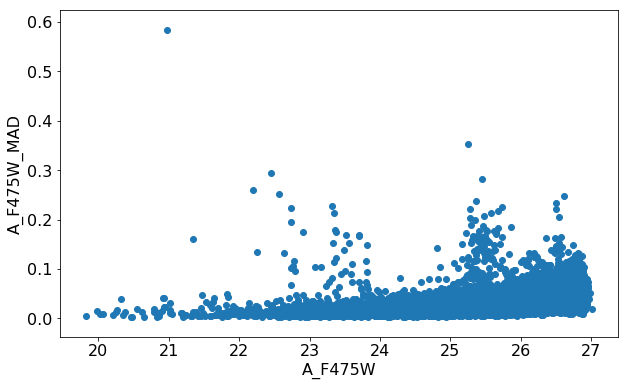

In [8]:
job = HSC_service.launch_job_async("""
SELECT MatchID, MatchRA, MatchDec, TargetName, NumImages, NumVisits, A_F475W, A_F475W_MAD, A_F475W_N
FROM dbo.SumMagAper2CatView
WHERE 
   A_F475W_N >= 10
   AND
   CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',16.117562,2.162183,0.1))=1
   """)
HSC_results = job.get_results()
HSC_results.pprint()

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(10,6))
pylab.scatter(HSC_results['A_F475W'], HSC_results['A_F475W_MAD'])
pylab.xlabel('A_F475W')
pylab.ylabel('A_F475W_MAD')

Get the individual A_F475W measurements for the most variable object in the list and plot the light curve.

 MatchID       MatchRA            MatchDec      TargetName NumImages NumVisits      A_F475W           A_F475W_MAD     A_F475W_N
--------- ------------------ ------------------ ---------- --------- --------- ------------------ ------------------- ---------
102334412 16.130003898898298 2.1655152822114401     IC1613        26        14 20.970849990844702 0.58440017700195301        12
Launched query: '
SELECT SourceID, ImageID, SourceRA, SourceDec, D, Filter, Detector, MagAper2, StartMJD
FROM dbo.DetailedCatalog
WHERE 
   MatchID=102334412
   AND Detector='ACS/WFC' AND Filter='F475W' AND Det='Y'
ORDER BY StartMJD
'
Retrieving async. results...
Query finished.
   SourceID   ImageID      SourceRA          SourceDec               D          Filter Detector      MagAper2           StartMJD     
------------- ------- ------------------ ------------------ ------------------- ------ -------- ------------------ ------------------
4000999067867   69735   16.1300039661166 2.1655155723933301    1.072

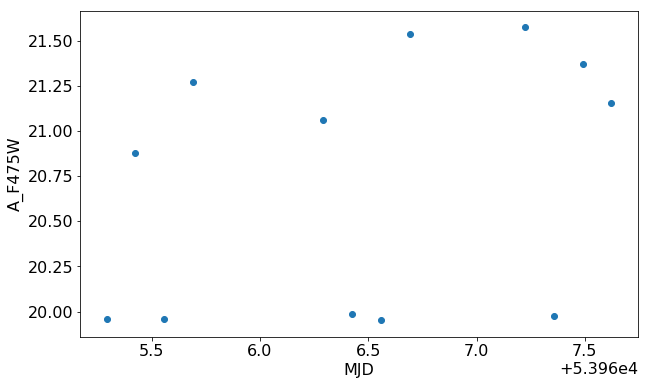

In [6]:
madvalues = HSC_results['A_F475W_MAD']
i = numpy.argmax(madvalues)
print(HSC_results[i])

matchid = HSC_results['MatchID'][i]
job = HSC_service.launch_job_async("""
SELECT SourceID, ImageID, SourceRA, SourceDec, D, Filter, Detector, MagAper2, StartMJD
FROM dbo.DetailedCatalog
WHERE 
   MatchID={}
   AND Detector='ACS/WFC' AND Filter='F475W' AND Det='Y'
ORDER BY StartMJD
""".format(matchid))
HSC_details = job.get_results()
# HSC_details.sort('StartMJD')
HSC_details.pprint()

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(10,6))
pylab.scatter(HSC_details['StartMJD'], HSC_details['MagAper2'])
pylab.xlabel('MJD')
pylab.ylabel('A_F475W')

## Create a color-magnitude diagram for the Small Magellanic Cloud
Do a search around the SMC with a 2 degree radius for objects with ACS F555W and F814W measurements.  Note this is a large query that takes about 2 minutes to run. See <a href="http://archive.stsci.edu/hst/hsc/help/use_case_2_v3.html" target="_blank">HSC Use Case 2</a> for more details.

In [7]:
t0 = time.time()
job = HSC_service.launch_job_async("""
SELECT MatchID, MatchRA, MatchDec, CI, A_F555W, A_F814W
FROM dbo.SumMagAper2CatView
WHERE A_F555W_N > 0 and A_F814W_N > 0
    AND CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',13.1866,-72.8286,0.5))=1
   """)
HSC_results = job.get_results()
print("Query completed in {:.1f} sec".format(time.time()-t0))
HSC_results.pprint()

Launched query: '
SELECT MatchID, MatchRA, MatchDec, CI, A_F555W, A_F814W
FROM dbo.SumMagAper2CatView
WHERE A_F555W_N > 0 and A_F814W_N > 0
    AND CONTAINS(POINT('ICRS', MatchRA, MatchDec),CIRCLE('ICRS',13.1866,-72.8286,0.5))=1
   '
Retrieving async. results...


ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 3))



ValueError: No table found

Plot the color-magnitude diagram for the ~100k points retrieved from the database.  This uses kernel density estimate for the crowded plot, which takes a minute or two to complete.

In [ ]:
f555w = HSC_results['A_F555W']
f814w = HSC_results['A_F814W']
VminusI = f555w-f814w
CI = HSC_results['CI']
w = numpy.where((CI>0.9) & (CI<1.6) & (VminusI > -1.5) & (VminusI < 1.5))
print(len(w[0]),"points remaining after CI and V-I filtering")

# Calculate the point density
x = numpy.array(VminusI[w])
y = numpy.array(f555w[w])
xy = numpy.vstack([x,y])
from scipy.stats import gaussian_kde
t0 = time.time()
z = gaussian_kde(xy)(xy)
print("kde took {:.1f} sec".format(time.time()-t0))

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

pylab.rcParams.update({'font.size': 16})
pylab.figure(1,(12,10))
pylab.scatter(x, y, c=z, s=2, edgecolor='', cmap='plasma')
pylab.autoscale(tight=True)
pylab.xlabel('V-I')
pylab.ylabel('V')
pylab.gca().invert_yaxis()
pylab.colorbar()
pylab.text(.17,.93,'{:d} stars in SMC'.format(len(x)),
       horizontalalignment='center',
       transform=pylab.gca().transAxes)
pylab.savefig("smc_colormag.png")

# Appendix: Documentation on the Standards

### Table Access Protocol 
* IVOA standard for RESTful web service access to tabular data
* http://www.ivoa.net/documents/TAP/

### Hubble Source Catalog v3
* Catalog created at MAST by combining the tens of thousands of visit-based source lists in the Hubble Legacy Archive (HLA) into a single master catalog. 
* https://archive.stsci.edu/hst/hsc/

### Astronomical Query Data Language (2.0)
* IVOA standard for querying astronomical data in tabular format, with geometric search support
* http://www.ivoa.net/documents/latest/ADQL.html

### TapPlus 
* Module created by ESAC Space Data Centre
* http://astroquery.readthedocs.io/en/latest/utils/tap.html


 